In [1]:
# Import necessary libraries
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [4]:
# Define paths for the train and test datasets
train_path = "C:\\Users\\ASHWITHA PN\\Downloads\\cats vs dogs\\train_data_small\\train_data_small"
test_path = "C:\\Users\\ASHWITHA PN\\Downloads\\cats vs dogs\\test_data_small\\test_data_small"

In [5]:
# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

In [6]:
# Without Data augmentation generator for training data
train_data_gen = ImageDataGenerator(
    rescale=1./255
)
# With Data augmentation generator for training data
train_data_gen_aug = ImageDataGenerator( rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False
)

In [7]:
# without data augmentation
# Train data without augmentation
train_generator = train_data_gen.flow_from_directory(train_path,target_size=(img_height, img_width),
    batch_size=batch_size, color_mode='rgb', class_mode='binary', shuffle=True
)

# Test data
test_generator = train_data_gen.flow_from_directory(test_path,target_size=(img_height, img_width),
    batch_size=batch_size,color_mode='rgb',class_mode='binary',shuffle=False
)

Found 2002 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
# with Data augmentation
# Train data
train_generator_aug = train_data_gen_aug.flow_from_directory(train_path,target_size=(img_height, img_width),
    batch_size=batch_size,color_mode='rgb',class_mode='binary',shuffle=True
)

# Test data
test_generator_aug = train_data_gen_aug.flow_from_directory(test_path,target_size=(img_height, img_width),
    batch_size=batch_size, color_mode='rgb', class_mode='binary', shuffle=False
)

Found 2002 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Class indices:", class_indices)
print("Class names:", class_names)

Class indices: {'cat': 0, 'dog': 1}
Class names: ['cat', 'dog']


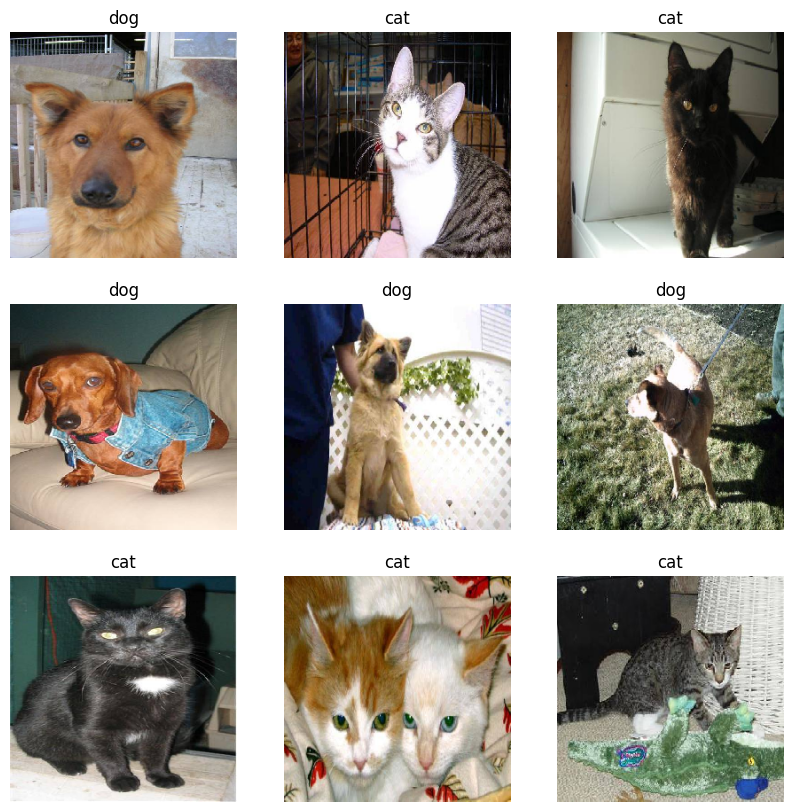

In [11]:
# Function to map index to class name
def index_to_class(index, generator):
    return list(generator.class_indices.keys())[list(generator.class_indices.values()).index(index)]

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(index_to_class(labels[i], train_generator))
    plt.axis("off")
plt.show()

In [20]:
# CNN model with early stopping without data argumentation
# Define the CNN model
cnn_model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Training with early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history_1 = cnn_model_1.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
63/63 [==============================] - 22s 265ms/step - loss: 0.9173 - accuracy: 0.5654 - val_loss: 0.8867 - val_accuracy: 0.5100
Epoch 2/50
63/63 [==============================] - 13s 211ms/step - loss: 0.7764 - accuracy: 0.5939 - val_loss: 0.7768 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 13s 209ms/step - loss: 0.7250 - accuracy: 0.6109 - val_loss: 0.8379 - val_accuracy: 0.4875
Epoch 4/50
63/63 [==============================] - 13s 211ms/step - loss: 0.6870 - accuracy: 0.6499 - val_loss: 0.7254 - val_accuracy: 0.5350
Epoch 5/50
63/63 [==============================] - 14s 216ms/step - loss: 0.5880 - accuracy: 0.7033 - val_loss: 0.8318 - val_accuracy: 0.5425
Epoch 6/50
63/63 [==============================] - 13s 206ms/step - loss: 0.5529 - accuracy: 0.7238 - val_loss: 0.7658 - val_accuracy: 0.5375
Epoch 7/50
63/63 [==============================] - 13s 206ms/step - loss: 0.5160 - accuracy: 0.7572 - val_loss: 0.8348 - val_accuracy: 0.5925

In [22]:
# Evaluate the CNN model 1 on the test data and train data
train_loss, train_accuracy = cnn_model_1.evaluate(train_generator)
test_loss, test_accuracy = cnn_model_1.evaluate(test_generator)

13/13 [==============================] - 2s 120ms/step - loss: 0.5636 - accuracy: 0.7275


In [23]:
# CNN model with early stopping with data argumentation
# Define the CNN model
cnn_model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
# Training with early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

#train the cnn model
history_2 = cnn_model_2.fit(
    train_generator_aug,
    epochs=50,
    validation_data=test_generator_aug,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
63/63 [==============================] - 52s 739ms/step - loss: 0.9451 - accuracy: 0.5504 - val_loss: 1.8081 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 49s 770ms/step - loss: 0.8305 - accuracy: 0.5849 - val_loss: 1.3297 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 47s 742ms/step - loss: 0.7682 - accuracy: 0.5974 - val_loss: 0.9649 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 50s 800ms/step - loss: 0.7562 - accuracy: 0.5834 - val_loss: 1.1267 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 47s 744ms/step - loss: 0.7177 - accuracy: 0.6209 - val_loss: 0.7596 - val_accuracy: 0.5075
Epoch 6/50
63/63 [==============================] - 47s 752ms/step - loss: 0.6912 - accuracy: 0.6099 - val_loss: 0.6692 - val_accuracy: 0.5800
Epoch 7/50
63/63 [==============================] - 49s 780ms/step - loss: 0.6687 - accuracy: 0.6279 - val_loss: 0.6936 - val_accuracy: 0.5650

In [26]:
# Evaluate the CNN model on the train data and test data
train_loss, train_accuracy = cnn_model_2.evaluate(train_generator_aug)
test_loss, test_accuracy = cnn_model_2.evaluate(test_generator_aug)

13/13 [==============================] - 8s 625ms/step - loss: 0.3886 - accuracy: 0.8175


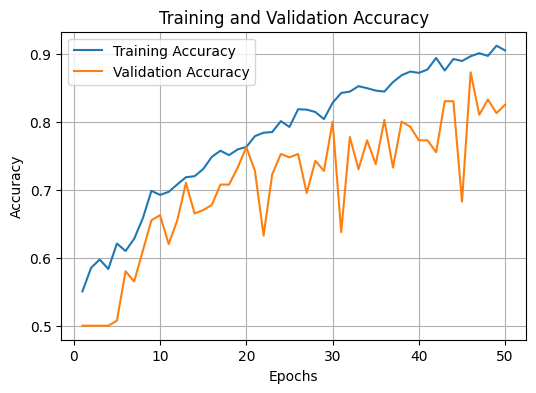

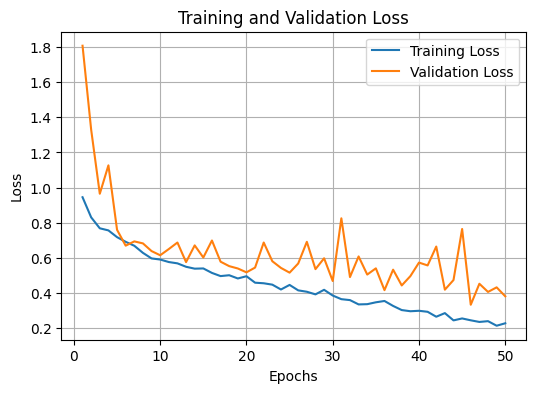

In [27]:
#plotting the graph for accuracy and loss

# Plot training and validation accuracy
train_accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation loss
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


13/13 [==============================] - 7s 515ms/step


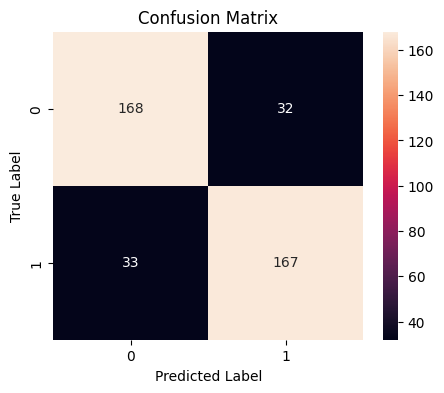

In [28]:
# Calculate and PLot the confusion matrix
y_pred_cnn = cnn_model_2.predict(test_generator_aug)
y_pred_binary = np.round(y_pred_cnn)
true_labels = np.array(test_generator_aug.classes)
cm_cnn = confusion_matrix(true_labels, y_pred_binary)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
# Generate a classification report
y_pred_cnn = cnn_model_2.predict(test_generator_aug)
y_pred_binary = np.round(y_pred_cnn)
true_labels = np.array(test_generator_aug.classes)
class_report = classification_report(true_labels, y_pred_binary)
print(class_report)

13/13 [==============================] - 8s 587ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       200
           1       0.84      0.84      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [9]:
# Generate features and labels from the training and test data generator
train_features, train_labels = [], []
for i in range(len(train_generator_aug)):
    batch_data, batch_labels = train_generator_aug[i]
    train_features.extend(batch_data)
    train_labels.extend(batch_labels)

train_features = np.array(train_features)
train_labels = np.array(train_labels)

test_features, test_labels = [], []
for i in range(len(test_generator_aug)):
    batch_data, batch_labels = test_generator_aug[i]
    test_features.extend(batch_data)
    test_labels.extend(batch_labels)

test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [11]:
# Create an SVM classifier with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)

# Flatten the feature vectors
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train the SVM model on the training features and labels
svm_model.fit(train_features, train_labels)
svm_predictions = svm_model.predict(test_features)

In [12]:
# Calculate the accuracy of the SVM model
accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Model Accuracy: {accuracy:.2f}')
# Generate a classification report
class_report = classification_report(test_labels, svm_predictions)
print(class_report)

SVM Model Accuracy: 0.54
              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56       200
         1.0       0.54      0.49      0.52       200

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400



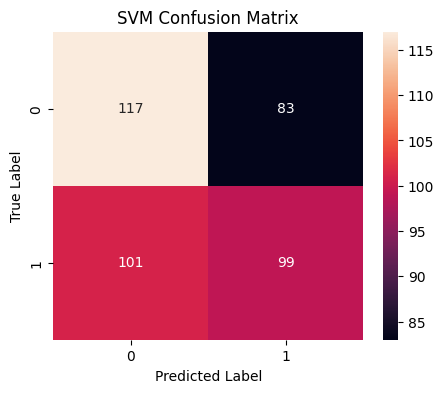

In [13]:
#Plot the confusion matrix as a heatmap
cm_svm = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d')
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

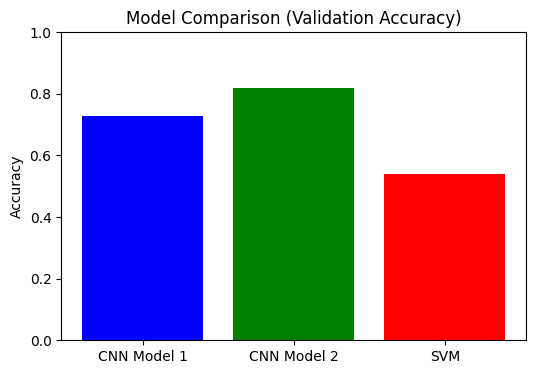

In [16]:
# Define the accuracies for all three models
cnn1_train_accuracy = 0.8032
cnn1_val_accuracy = 0.7275

cnn2_train_accuracy = 0.9161
cnn2_val_accuracy = 0.8175

svm_accuracy = 0.54

# Create a bar chart to compare the accuracies
models = ['CNN Model 1', 'CNN Model 2', 'SVM']
accuracies = [cnn1_val_accuracy, cnn2_val_accuracy, svm_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['b', 'g', 'r'])
plt.title('Model Comparison (Validation Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

plt.show()